# Find the GW skies which would have been detected

In [1]:
#!/usr/bin/env python
"""step2_find_detected_GW_skies.ipynb: a notebook to find detectable GW skies """

__author__ = "Chiara M. F. Mingarelli"
__copyright__ = "Copyright 2016, GWASAP project"
__credits__ = ["Chiara Mingarelli"]
__license__ = "GPL"
__version__ = "0.0.1"
__maintainer__ = "Chiara Mingarelli"
__email__ = "mingarelli@gmail.com"

In [71]:
from __future__ import division
import os
from IPython.display import display, Math, Latex
import math
from math import sqrt, cos, sin, pi
import numpy as np
import statsmodels.api as sm
from scipy.interpolate import interp1d
import scipy.integrate
import matplotlib.pyplot as plt
import matplotlib.mlab as ml
from matplotlib.ticker import FormatStrFormatter, LinearLocator, NullFormatter, NullLocator, MultipleLocator
import matplotlib.ticker
import matplotlib.colors
from matplotlib.font_manager import FontProperties
from matplotlib import rc, text
import healpy as hp
#import plot_mpI2
from astropy import units as u
from astropy.coordinates import SkyCoord
from astropy.io import fits
from scipy.stats import norm
import matplotlib.mlab as mlab
from scipy.stats import lognorm
from scipy import stats


%matplotlib inline
%config InlineBackend.figure_format = "retina"

In [72]:
nside = 2**6
freq_choice = np.loadtxt("../gw_freqs1.dat") #available GW frequencies

In [110]:
files = []
# this is the path to where you store all the GW realizations
for i in os.listdir('../../rusty_data/KH13_Reg_Sigma_dex/87/'):
    if i.endswith('.txt'):
        files.append(i)

In [111]:
print(len(files))

10000


In [81]:
def find_nearest(array ,value):
    idx = (np.abs(array-value)).argmin()
    return array[idx]

In [82]:
fig_width_pt = 245.27 #513.17           # Get this from LaTeX using \showthe\columnwidth
inches_per_pt = 1.0/72.27               # Convert pt to inches
golden_mean = (np.sqrt(5)-1.0)/2.0      # Aesthetic ratio
fig_width = fig_width_pt*inches_per_pt  # width in inches
fig_height =fig_width*golden_mean       # height in inches
fig_size = [fig_width,fig_height]

params = {'backend': 'pdf',
        'axes.labelsize': 7,
        'lines.markersize': 4,
        'font.size': 7,
        'xtick.major.size':6,
        'xtick.minor.size':3,  
        'ytick.major.size':6,
        'ytick.minor.size':3, 
        'xtick.major.width':0.5,
        'ytick.major.width':0.5,
        'xtick.minor.width':0.5,
        'ytick.minor.width':0.5,
        'lines.markeredgewidth':1,
        'axes.linewidth':1.2,
        'legend.fontsize': 7,
        'xtick.labelsize': 7,
        'ytick.labelsize': 7,
        'savefig.dpi':200,
        'path.simplify':True,
        'font.family': 'serif',
        #'font.serif':'Times',
        'text.latex.preamble': [r'\usepackage{amsmath}'],
        'text.usetex':True,
        #'axes.color_cycle': ['b', 'lime', 'r', 'purple', 'g', 'c', 'm', 'orange', 'darkblue', \
        #                        'darkcyan', 'y','orangered','chartreuse','brown','deeppink','lightgreen', 'k'],
        #'font.serif':cm,
        'figure.figsize': fig_size}
plt.rcParams.update(params)

In [112]:
#RA_tot, DEC_tot, gw_freq_vec, strain_vec, mchirp_rec,q_rec, gal_cat_name, dist_list, mstar_list, 
#save_p, gal_choice, T_z_list, mergRate_list, t2c_list, z_list, r_inf_list, friction_list, 
#hardening_list, num_zeros

file_s = []
gal_z = []
stall = []
r_inf = []
no_of_skies = len(files)

# remember to update the path here to the one with all your realizations
for jj in range(no_of_skies):
    filename = files[jj]
    
    sim_sky = np.genfromtxt("../../rusty_data/KH13_Reg_Sigma_dex/87/" + str(filename)) 
    if(len(sim_sky) != 0):
        try:    
            RA = sim_sky[:,0] #phi, add pi to this for healpix maps
            file_s.append(RA.size) # number of galaxies in file
            gal_z.append(sim_sky[:,14])
            stall.append(sim_sky[0][18])
        except Exception as e:
            fake = np.zeros((1, 19))
            fake[0] = sim_sky
            RA = fake[:,0] #phi, add pi to this for healpix maps
            file_s.append(RA.size) # number of galaxies in file
            gal_z.append(fake[:,14])
            stall.append(fake[0][18])


In [113]:
print(len(file_s))

10000


In [88]:
def hist_weight(lst):
    return np.ones_like(lst)/len(lst)

def auto_bin(bin_size, min_edge, max_edge):
    # for nice looking bins
    N = (max_edge-min_edge)/bin_size; Nplus1 = N + 1
    bin_list = np.linspace(min_edge, max_edge, Nplus1)
    return bin_list

In [114]:
hist_bin = auto_bin(.2, .1, 4)
print(gal_z[1][0])

0.2756605311648351


/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:7: DeprecationWarning: object of type <class 'float'> cannot be safely interpreted as an integer.
  import sys


In [115]:
no_of_skies = len(file_s)
#CHANGE BACK TO 50
ran_z = np.random.choice(gal_z, 50, replace=False) # choose a sample of 50 random galaxies

In [116]:
len(ran_z)

50

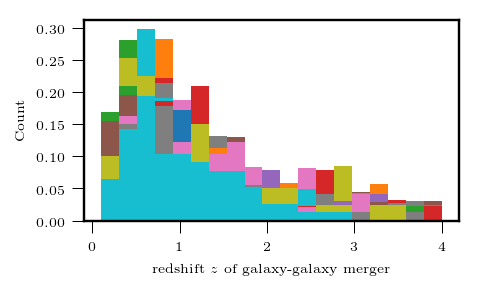

In [117]:
test = []
for i in range(len(ran_z)):
    test.append(plt.hist(ran_z[i], hist_bin, weights = hist_weight(ran_z[i])))
plt.ylabel("Count")
plt.xlabel("redshift $z$ of galaxy-galaxy merger")  
plt.tight_layout()
plt.savefig("plots_sigma_87/step_2/87_redshift_kh13.pdf")


In [ ]:

no_of_bins = hist_bin.size
avg_test = []
tMean = []
tStd = []

for j in range(no_of_bins-1):
    for i in range(len(ran_z)):
        inst = plt.hist(gal_z[i], hist_bin, weights = hist_weight(gal_z[i]))[0][j]
        #print inst, i, j
        avg_test.append(inst)
    tMean.append(np.mean(avg_test))
    tStd.append(np.std(avg_test))
    avg_test = []
    print ("Mean value for j is ", tMean[j], j)


In [ ]:
ind = avg_test[0][1]

In [ ]:
print ind[0:19]

In [ ]:
print(tMean)
print(tStd)

In [28]:
hist_bin = hist_bin[:-1]

In [ ]:
fig, ax = plt.subplots()
ax.bar(hist_bin, tMean, yerr=tStd,edgecolor = 'black', width = 0.2, alpha = 0.8)
plt.xlim(0,4)
plt.ylim(0,.8)
majorLocator = MultipleLocator(.3)
#minorLocator = MultipleLocator(5)
#ax.xaxis.set_minor_locator(minorLocator)
ax.xaxis.set_major_locator(majorLocator)
#ax.set_xticks(np.around(ind[0:19],1))
#for tick in ax.xaxis.get_major_ticks():
#    tick.label1.set_horizontalalignment('center')
#    tick.label.set_fontsize(6) 
plt.ylabel("Probability")
plt.xlabel("Redshift $z$ of galaxy-galaxy merger")
plt.tight_layout()

plt.savefig("plots_sigma_58/step_2/58_redshift_avg_kh13_sig.pdf")

In [50]:
max(stall)

2.0

In [118]:
weightsSt =  np.ones_like(stall)/len(stall)

/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:3: DeprecationWarning: object of type <class 'numpy.float64'> cannot be safely interpreted as an integer.
  This is separate from the ipykernel package so we can avoid doing imports until
/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:9: MatplotlibDeprecationWarning: scipy.stats.norm.pdf
  if __name__ == '__main__':


82.5811 9.563368799225511


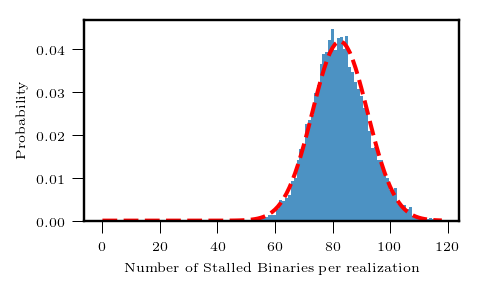

In [119]:
bin_size = 1; min_edge = 0; max_edge = max(stall)
N = (max_edge-min_edge)/bin_size; Nplus1 = N + 1
bin_list = np.linspace(min_edge, max_edge, Nplus1)

(mu, sigma) = norm.fit(stall)

print(mu, sigma)

y = mlab.normpdf(bin_list, mu, sigma)
l = plt.plot(bin_list, y, 'r--', linewidth=2)

plt.hist(stall, bin_list, weights = weightsSt, alpha =0.8, align='left')
plt.ylabel("Probability")
plt.xlabel("Number of Stalled Binaries per realization")
plt.tight_layout()
#plt.xlim(0,20)
plt.savefig("plots_sigma_87/step_2/87_no_stalled_kh13.pdf")

In [53]:
print(mu, sigma)

0.011647755798774978 0.11006614243785383


In [120]:
weightsG = np.ones_like(file_s)/len(file_s)

In [121]:
min(file_s)

24

/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:3: DeprecationWarning: object of type <class 'float'> cannot be safely interpreted as an integer.
  This is separate from the ipykernel package so we can avoid doing imports until
/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:10: MatplotlibDeprecationWarning: scipy.stats.norm.pdf
  # Remove the CWD from sys.path while we load stuff.


67.292 18.608388860941186


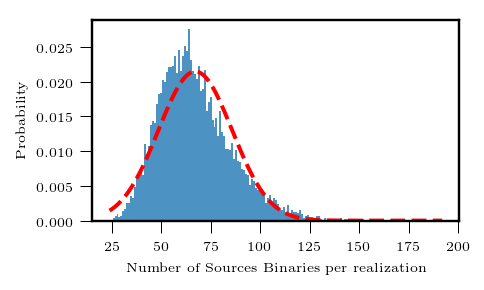

In [122]:
bin_size = 1; min_edge = min(file_s); max_edge = max(file_s)
N = (max_edge-min_edge)/bin_size; Nplus1 = N + 1
bin_list = np.linspace(min_edge, max_edge, Nplus1)

(mu, sigma) = norm.fit(file_s)
print(mu, sigma)



y = mlab.normpdf(bin_list, mu, sigma)
l = plt.plot(bin_list, y, 'r--', linewidth=2)
plt.hist(file_s, bin_list, weights = weightsG, alpha =0.8, align='left')

plt.ylabel("Probability")
plt.xlabel("Number of Sources Binaries per realization")
plt.tight_layout()

plt.savefig("plots_sigma_87/step_2/87_no_sources_kh13.pdf")

In [ ]:
mu, sigma

In [ ]:
print(stall)
print(files_s)

In [ ]:
# File contents are the following:
#RA_tot, DEC_tot, gw_freq_vec, strain_vec, mchirp_rec,q_rec, gal_cat_name, dist_list, mstar_list, 
#save_p, gal_choice, T_z_list, mergRate_list, t2c_list, z_list, r_inf_list, friction_list, 
#hardening_list, num_zeros

In [ ]:
no_of_skies = len(files)

for jj in range(no_of_skies):
    filename = files[jj]
    
    sim_sky = np.genfromtxt("../../rusty_data/KH13_Reg_Sigma/"+str(filename))
    #sim_sky = np.genfromtxt("../../rusty_data/KH13_Reg_Sigma/29dex/"+str(filename))


    
    RA = sim_sky[:,0] #phi, add pi to this for healpix maps
    DEC = sim_sky[:,1] #theta
    freq = sim_sky[:,2]
    strain = sim_sky[:,3]
    mchirp_rec = sim_sky[:,4]
    q_rec = sim_sky[:,5]
    
    gal_cat_name = np.genfromtxt("../../rusty_data/KH13_Reg_Sigma/"+str(filename), usecols = 6, dtype='S13')
    #gal_cat_name = np.genfromtxt("../../rusty_data/KH13_Reg_Sigma/29dex/"+str(filename), usecols = 6, dtype='S13')


    dist_list = sim_sky[:,7]
    mstar_list = sim_sky[:,8]
    save_p = sim_sky[:,9]
    gal_choice = sim_sky[:,10] 
    T_z_list = sim_sky[:,11] 
    mergRate_list =sim_sky[:,12] 
    t2c_list = sim_sky[:,13] 
    z_list = sim_sky[:,14] 
    file_size = strain.size # number of galaxies in file

    for ii in range(file_size):
        look_up_freq = find_nearest(freq_choice, freq[ii]) # what is the closest GW freq (out of 87)?
        healpix_map = hp.read_map('../../healpix_maps/strain_map_freq_'+str(look_up_freq)+'Hz.fits')
        pixNo = hp.pixelfunc.ang2pix(nside, pi/2-DEC[ii], pi+RA[ii]) # ± angles for correct display in healpix
        pixStrain = healpix_map[pixNo]
        #hp.mollview(healpix_map)
        if strain[ii] > pixStrain and strain[ii]>1e-15:
            dest_file = "../../detectedSkies/kh13_sig_detected_skies_01.txt"    
            with open(dest_file, 'a+') as f:
                f.write('{0} {1} {2} {3} {4} {5} {6} {7} {8} {9} {10} {11} {12} {13} {14}\n'.format(RA[ii], \
                DEC[ii], look_up_freq, strain[ii], filename, mchirp_rec[ii],q_rec[ii], dist_list[ii], mstar_list[ii], \
                save_p[ii], gal_choice[ii], T_z_list[ii], mergRate_list[ii], t2c_list[ii], z_list[ii] ))
    #print "Realization "+str(jj)+", "+str((jj/no_of_skies)*100)+"%"